# **Brazilian Tweet Sentiment Analysis**

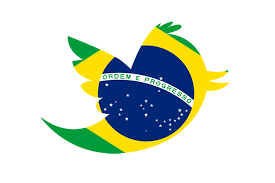
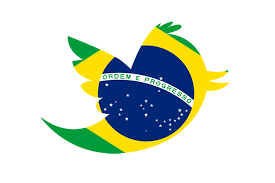

## **Aim**
This project aims to develop a sentiment analysis model for Brazilian Portuguese tweets using NLP and machine learning. The goal is to classify tweets as positive or negative, providing insights into public opinion and trends.

## **Introduction**
Twitter is a key platform for public opinion. Sentiment analysis helps categorize tweets as positive or negative. This project focuses on Brazilian Portuguese, requiring preprocessing techniques like text cleaning, stopword removal, and stemming. We will apply machine learning models to classify sentiments and analyze trends. The final model can support applications in brand monitoring, political analysis, and customer feedback evaluation.

## Requirements

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',None)

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB 
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

import nltk
nltk.download("stopwords")
import re
from nltk.corpus import stopwords
import string

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Import Data

In [3]:
df=pd.read_csv("/kaggle/input/TweetSentimentBR/Train.csv")

## EDA (Exploratory Data Analysis)

In [4]:
df.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1049158578504916992,@Vini_Arisato eu espero que não,Mon Oct 08 04:44:32 +0000 2018,0,:(
1,1049104603332169728,me diz aí o que vai ser do serviço social com ...,Mon Oct 08 01:10:03 +0000 2018,1,:)
2,1050780236856651776,"inclusive, os nomes que eu uso aqui são de tes...",Fri Oct 12 16:08:25 +0000 2018,1,:)
3,1047555890654728192,@rangerlol1 Hora da panelinha começar a passar...,Wed Oct 03 18:36:01 +0000 2018,1,:)
4,1046965203701829632,Meu neosoro tá acabando,Tue Oct 02 03:28:50 +0000 2018,0,:(


In [5]:
df.shape

(50000, 5)

In [6]:
df.isnull().sum()

id            0
tweet_text    0
tweet_date    0
sentiment     0
query_used    0
dtype: int64

In [7]:
df['sentiment'].value_counts()

sentiment
0    25000
1    25000
Name: count, dtype: int64

## Data Visualization

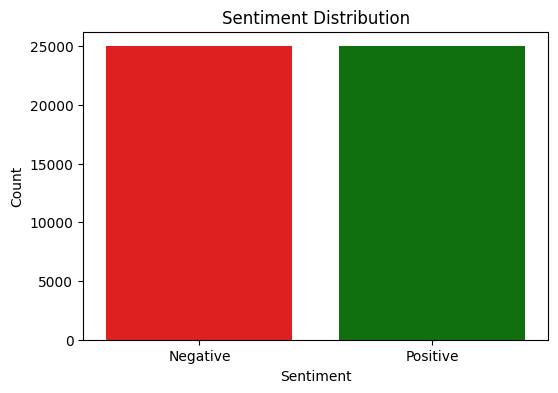

In [47]:
sentiment_counts = df['sentiment'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=["red", "green"])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["Negative", "Positive"])
plt.title("Sentiment Distribution")
plt.show()

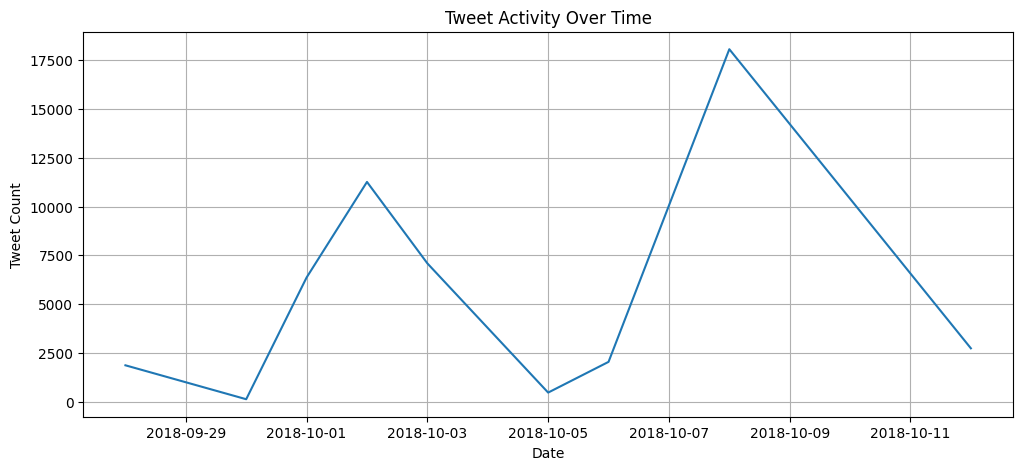

In [48]:
df['tweet_date'] = pd.to_datetime(df['tweet_date'])  # Convert to datetime
df_time = df.groupby(df['tweet_date'].dt.date)['sentiment'].count()  # Count tweets per day

plt.figure(figsize=(12, 5))
df_time.plot()
plt.xlabel("Date")
plt.ylabel("Tweet Count")
plt.title("Tweet Activity Over Time")
plt.grid()
plt.show()

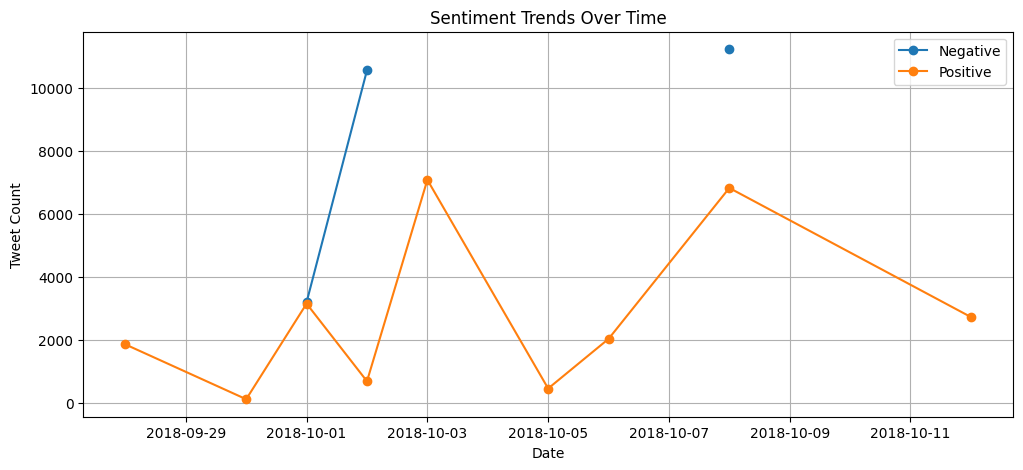

In [52]:
df['tweet_date'] = pd.to_datetime(df['tweet_date'])
df_time_sentiment = df.groupby([df['tweet_date'].dt.date, 'sentiment']).size().unstack()

df_time_sentiment.plot(figsize=(12, 5), marker='o')
plt.xlabel("Date")
plt.ylabel("Tweet Count")
plt.title("Sentiment Trends Over Time")
plt.legend(["Negative", "Positive"])
plt.grid()
plt.show()

## Preprocess Text

In [9]:
stemmer=nltk.SnowballStemmer("portuguese")
stopword=set(stopwords.words("portuguese"))
def clean_text(df,text_column):
    # Convert to lowercase
    df[text_column] = df[text_column].str.lower()
    
    # Remove unwanted characters
    df[text_column] = df[text_column].str.replace('[^\w\s]', '', regex=True)
    df[text_column] = df[text_column].str.replace('\w*\d\w*', '', regex=True)
    df[text_column] = df[text_column].str.replace('\n', '', regex=True)
    df[text_column] = df[text_column].str.replace('\r', '', regex=True)
    df[text_column] = df[text_column].str.replace('https?://\S+|www\.\S+', '', regex=True)
    df[text_column] = df[text_column].str.replace('<.*?>+', '', regex=True)
    df[text_column] = df[text_column].str.replace('\[.*?\]', '', regex=True)
    
    # Remove stopwords and apply stemming
    df[text_column] = df[text_column].apply(lambda x: ' '.join(
        stemmer.stem(word) 
        for word in x.split() 
        if word not in stopword
    ))
    return df[text_column]

In [11]:
df.iloc[0]["tweet_text"]

'@Vini_Arisato eu espero que não '

In [12]:
df["tweet_text"]=clean_text(df,"tweet_text")

In [13]:
df.iloc[0]["tweet_text"]

'vini_arisat esper'

## Word Cloud

In [14]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from PIL import Image
def wc(data,color):
    plt.figure(figsize=(10,10))
   # mask=np.array(Image.open('cloud.png'))
    wc=WordCloud(background_color=color,stopwords=STOPWORDS)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

## Word Cloud for Negative Texts

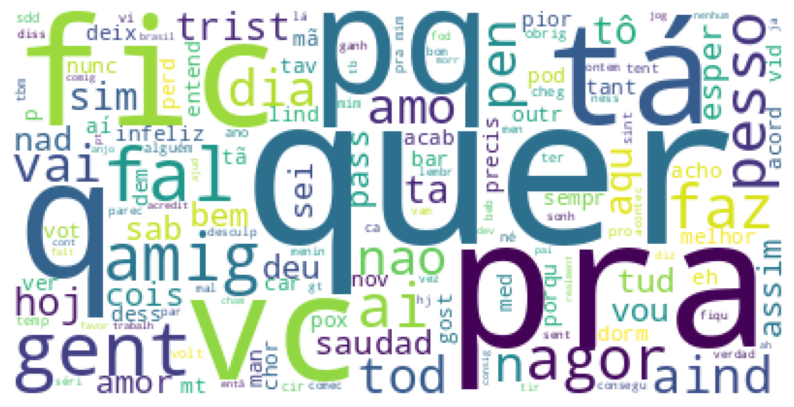

In [15]:
wc(df[df["sentiment"]==0]["tweet_text"],"white")

## Word Cloud for Positive Texts

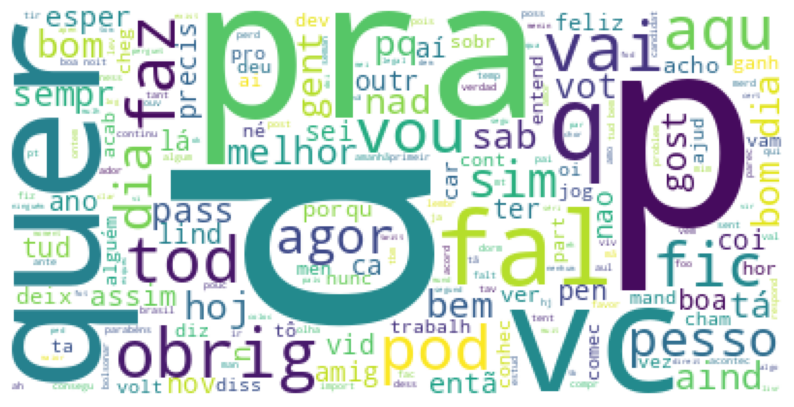

In [16]:
wc(df[df["sentiment"]==1]["tweet_text"],"white")

## The Most Used Words for Negative Texts

In [21]:
nltk.download('stopwords')

portuguese_stopwords = stopwords.words("portuguese") 

def get_top_ngrams(texts, ngram_range=(2, 3), top_n=10):
    vect = CountVectorizer(ngram_range=ngram_range, stop_words=portuguese_stopwords) 
    dtm = vect.fit_transform(texts)
    ngram_counts = dtm.sum(axis=0)
    ngrams_freq = [(word, ngram_counts[0, idx]) for word, idx in vect.vocabulary_.items()]
    return sorted(ngrams_freq, key=lambda x: x[1], reverse=True)[:top_n]

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
negative_text = df[df['sentiment'] == 0]['tweet_text']
negative_text_ngrams = get_top_ngrams(negative_text, ngram_range=(2, 2), top_n=20)
negative_text_ngrams

[('pra mim', 250),
 ('segund turn', 179),
 ('quer ter', 172),
 ('amo tant', 168),
 ('quer tant', 164),
 ('to trist', 163),
 ('tod mund', 156),
 ('quer ir', 141),
 ('fic trist', 123),
 ('vou ter', 117),
 ('tã trist', 116),
 ('tô trist', 116),
 ('bom dia', 111),
 ('amo dem', 106),
 ('tud bem', 103),
 ('melhor sonh', 100),
 ('ir pra', 86),
 ('vai ter', 86),
 ('quer pod', 76),
 ('to mt', 76)]

## The Most Used Words for Positive Texts

In [23]:
positive_text = df[df['sentiment'] == 1]['tweet_text']
positive_text_ngrams = get_top_ngrams(positive_text, ngram_range=(2, 2), top_n=20)
positive_text_ngrams

[('bom dia', 685),
 ('boa noit', 228),
 ('tud bem', 193),
 ('pra mim', 142),
 ('tod mund', 137),
 ('dia crianc', 116),
 ('fic feliz', 103),
 ('feliz dia', 103),
 ('vai ter', 102),
 ('segund turn', 89),
 ('boa sort', 86),
 ('pra vc', 85),
 ('aind bem', 82),
 ('pra faz', 76),
 ('vou ter', 71),
 ('dia pra', 70),
 ('pra ver', 69),
 ('vou faz', 68),
 ('qualqu cois', 65),
 ('hoj dia', 65)]

## Modelling

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',100)

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB 
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier  
from sklearn.naive_bayes import MultinomialNB    


def classification_test(x,y,vect,confusion_mtr=False):
    b=BernoulliNB()
    l=LogisticRegression()
    d=DecisionTreeClassifier()
    rf=RandomForestClassifier()
    h=GradientBoostingClassifier()
    a=AdaBoostClassifier()
    m=MultinomialNB()
    algos=[b,l,d,rf,h,a,b]

    algo_names=['Bernoulli NB','Logistic Regression','Decision Tree Classifier','Random Forest Classifier','Gradient Boosting Classifier','Ada Boost Classifier','Multinomial NB']

    accuracy=[]
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

    result=pd.DataFrame(columns=['Accuracy Score'],index=algo_names)

    for i, algo in enumerate(algos):
        x_train_dtm = vect.fit_transform(x_train)
        x_test_dtm = vect.transform(x_test)

        if hasattr(algo, 'fit'):
            x_train_dtm = x_train_dtm  
            x_test_dtm = x_test_dtm   

        p = algo.fit(x_train_dtm, y_train).predict(x_test_dtm)
        accuracy.append(accuracy_score(y_test, p))
        if confusion_mtr:
            cm = confusion_matrix(y_test, p)
            plt.figure(figsize=(5, 5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=algo.classes_, yticklabels=algo.classes_,cbar=None)
            plt.title(f"Confusion Matrix - {algo_names[i]}")
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.show()

    result['Accuracy Score']=accuracy

    r_table=result.sort_values('Accuracy Score',ascending=False)
    
        
        
    return r_table[['Accuracy Score']]

In [25]:
x=df["tweet_text"]
y=df["sentiment"]

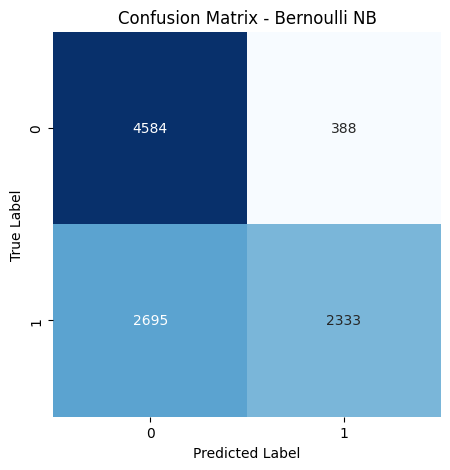

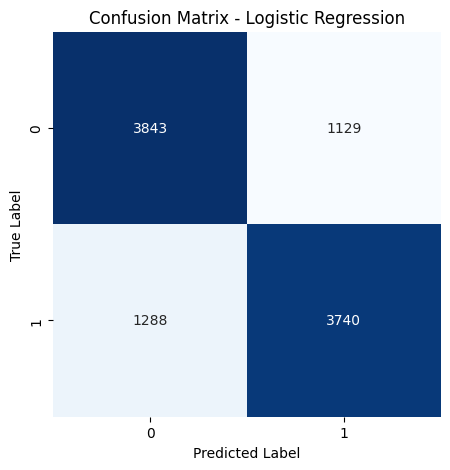

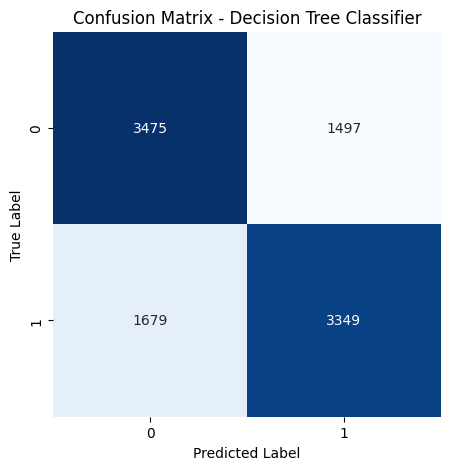

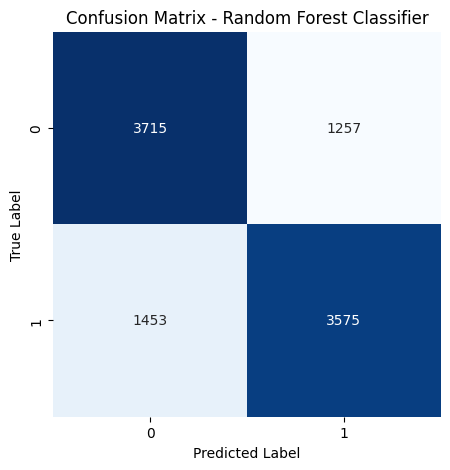

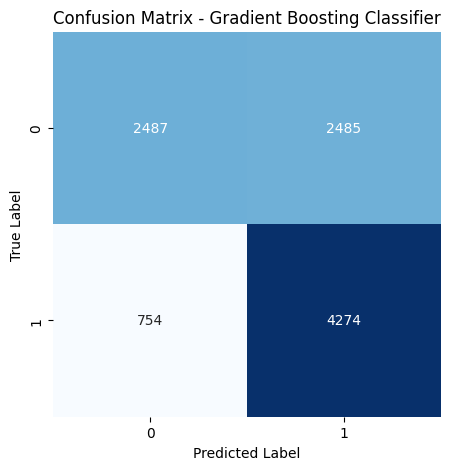

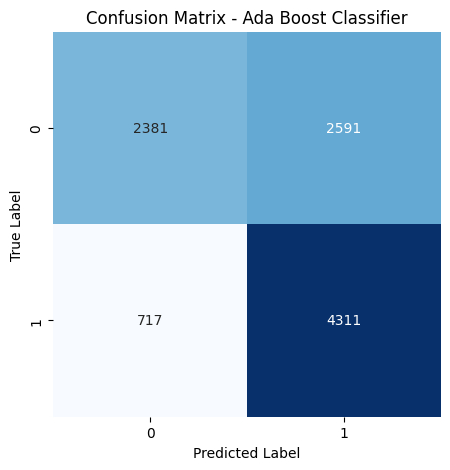

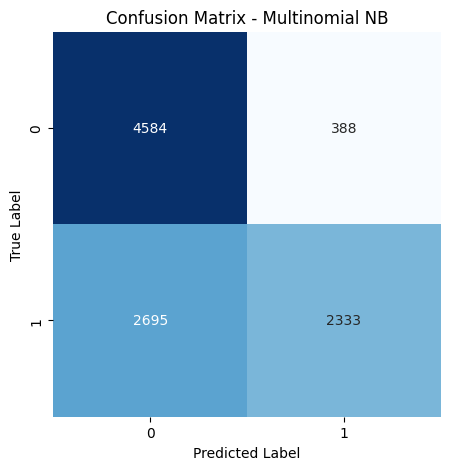

,Accuracy Score
Logistic Regression,0.7583
Random Forest Classifier,0.7290
Bernoulli NB,0.6917
Multinomial NB,0.6917
Decision Tree Classifier,0.6824
Gradient Boosting Classifier,0.6761
Ada Boost Classifier,0.6692


In [26]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(ngram_range=(1,2))
classification_test(x,y,vect,confusion_mtr=True)

In [27]:
vect = CountVectorizer(ngram_range=(1,2))
l=LogisticRegression()
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
x_train_dtm = vect.fit_transform(x_train)
x_test_dtm = vect.transform(x_test)
model=l.fit(x_train_dtm, y_train)

In [28]:
import joblib  

joblib.dump(model, 'logistic_regression_model.pkl')
joblib.dump(vect, 'vectorizer.pkl')

['vectorizer.pkl']

## Testing the Model

In [38]:
df_test=pd.read_csv('/kaggle/input/TweetSentimentBR/Test.csv')

In [39]:
df_test.head()

,id,tweet_text,tweet_date
0,1029570266916159488,@Ataylandia vc paga o meu e eu como o seu tau...,Wed Aug 15 03:27:34 +0000 2018
1,1030496040649142272,a mão ((((((( https://t.co/cdBTzTVCt6,Fri Aug 17 16:46:16 +0000 2018
2,1030496928755314688,@delucca geralmente a depressão é filha da ans...,Fri Aug 17 16:49:48 +0000 2018
3,1029559076815097856,SUPER INDICO!!! GRANDE PROFISSIONAL https://t...,Wed Aug 15 02:43:06 +0000 2018
4,1029551213866573830,@Leticia75917877 Boa sorte,Wed Aug 15 02:11:52 +0000 2018


In [40]:
df_test["tweet_text"]=clean_text(df_test,"tweet_text")

In [41]:
test_data= vect.transform(df_test["tweet_text"])
predictions=model.predict(test_data)

In [42]:
df_test["predictions"]=predictions

In [43]:
df_test.head()

,id,tweet_text,tweet_date,predictions
0,1029570266916159488,@Ataylandia vc paga o meu e eu como o seu tau...,Wed Aug 15 03:27:34 +0000 2018,1
1,1030496040649142272,a mão ((((((( https://t.co/cdBTzTVCt6,Fri Aug 17 16:46:16 +0000 2018,1
2,1030496928755314688,@delucca geralmente a depressão é filha da ans...,Fri Aug 17 16:49:48 +0000 2018,0
3,1029559076815097856,SUPER INDICO!!! GRANDE PROFISSIONAL https://t...,Wed Aug 15 02:43:06 +0000 2018,1
4,1029551213866573830,@Leticia75917877 Boa sorte,Wed Aug 15 02:11:52 +0000 2018,1


In [44]:
submission=pd.DataFrame({
    "id":df_test["id"],
    "sentiment":df_test["predictions"]
})

In [45]:
submission.to_csv("submission.csv",index=False)

## **Conclusion**
The sentiment analysis models demonstrated varying levels of accuracy. Logistic Regression performed the best with an accuracy of 75.83%, followed by Random Forest at 72.90%. Naïve Bayes classifiers (Bernoulli and Multinomial) achieved similar results at 69.17%, while Decision Tree, Gradient Boosting, and AdaBoost classifiers had slightly lower performance. These results highlight that Logistic Regression is a strong baseline for sentiment classification in Brazilian Portuguese tweets.